In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

torch.cuda.set_device(4)
torch.cuda.current_device()

import warnings
from pathlib import Path
from types import SimpleNamespace
from wrappers.transformer_wrapper import FairseqTransformerHub

from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub
from fairseq.data.multilingual.multilingual_utils import (
    EncoderLangtok,
    LangTokSpec,
    LangTokStyle,
    augment_dictionary,
    get_lang_tok,
)

import alignment.align as align

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import numpy as np
import json

from collections import defaultdict
import statistics

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'xtick.labelsize' : 20})
plt.rcParams.update({'ytick.labelsize' : 20})
plt.rcParams.update({'axes.titlesize' : 24})
plt.rcParams.update({'axes.labelsize' : 22})

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
model = 'bilingual'# bilingual/multilingual
model_size = 'small'
teacher_forcing = False # teacher forcing/free decoding
dataset = 'iwslt'

In [4]:
if model == 'bilingual':
    # Bilingual paths
    europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
    ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
    iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR']) / "tokenized"
    pre_layer_norm = False
    tokenizer = "bpe"
    #gold_dir = Path(os.environ['GOLD_ALIGNMENT_DATA_DIR'])

elif model == 'multilingual':
    # Multilingual paths
    ckpt_dir = Path(os.environ['M2M_CKPT_DIR'])
    iwslt14_dir = Path("./data/iwslt14")
    europarl_dir = Path("./data/de-en")
    pre_layer_norm = True
    tokenizer ="spm"

if dataset == 'iwslt':
    test_set_dir = iwslt14_dir
elif dataset == 'gold':
    test_set_dir = europarl_dir / "processed_data/"

In [7]:
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

if model == 'bilingual':
    # Choose model
    model_type = 'baseline'
    seed = 5498 # 2253  2453  5498  9240	9819

    hub = FairseqTransformerHub.from_pretrained(
        ckpt_dir / f"{model_type}/{seed}",
        checkpoint_file=f"checkpoint_best.pt",
        data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
        #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(), 
    )
    NUM_LAYERS = 6

elif model == 'multilingual':
    # Checkpoint names
    if model_size=='big':
        checkpoint_file = '1.2B_last_checkpoint.pt'
    else:
        checkpoint_file = '418M_last_checkpoint.pt'
    data_name_or_path='.'
    hub = FairseqMultilingualTransformerHub.from_pretrained(
        ckpt_dir,
        checkpoint_file=checkpoint_file,
        data_name_or_path=data_name_or_path,
        source_lang= 'de',
        target_lang= 'en',
        lang_pairs ='de-en')
    NUM_LAYERS = 12


## Get sample for analysis

In [6]:
# index in dataset
i = 3 # index in dataset
# 3, 100, 105, 107, 120 (example paper), 163 (error visible)
#test_set_dir = europarl_dir / "processed_data/"
#test_set_dir = iwslt14_dir / "tokenized/"
src = "de"
tgt = "en"

sample = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=None)

src_tensor = sample['src_tensor']
tgt_tensor = sample['tgt_tensor']
src_tok = sample['src_tok']

print(sample['src_word_sent'])
print(sample['tgt_word_sent'])

wir werden alle geboren. wir bringen kinder zur welt .

we &apos;re all born. we all bring our children into the world .



# Test set analysis

### Hallucinations Analysis

Save top 30 most common tokens from training data (Raunak et al., 2021)

In [129]:
import csv
from collections import Counter

europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
for lang in ['en', 'de']:
    with open(europarl_dir / f'processed_data/train.bpe.{lang}', encoding="utf-8") as fbpe:
        # BPE source sentences
        data_set = fbpe.read()

        split_it = data_set.split()
        counter_words = Counter(split_it)
        most_occur = counter_words.most_common(30)

        with open(f'results/top_30_{lang}.csv', 'w', encoding="utf-8") as csv_out:
            writer = csv.writer(csv_out)
            for row in most_occur:
                writer.writerow(row)
            #write.writerow(most_occur)


## Generate Translations

In [5]:
def get_greedy_decoding(hub, src_tensor, inference_step_args=None):
    tgt_tensor_free = []
    # Compute beam search (beam = 1 greedy decoding)
    for pred in hub.generate(src_tensor, 1, inference_step_args = inference_step_args):
        tgt_tensor_free.append(pred['tokens'])
        translation = hub.decode(pred['tokens'], hub.task.target_dictionary, as_string=True)

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    return tgt_tensor, translation

def contribution_source(total_rollout, src_tensor):
    # Get total source contribution
    src_total_alti = total_rollout[-1][:,:src_tensor.size(0)].sum(dim=-1)
    # We delete the first prediction (only source and bos contribution)
    src_total_alti = src_total_alti[1:]
    return src_total_alti
    

def get_translation(hub, i, args, target_input=True, prefix_subwords=None, contributions=True):
    """Get translation and total source contribution by ALTI"""
    
    if prefix_subwords is not None:
        # Add token to beginning of target sentence (prefix)
        if target_input:
            # Convert prefix word to token indices, and tensor (required for generate)
            token_idx = hub.task.tgt_dict.index(prefix_subwords)
            prefix_tokens = torch.tensor([[token_idx]]).to('cuda')

            inference_step_args={'prefix_tokens': prefix_tokens}

            # Get sample from test set
            sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
            src_tensor = sample['src_tensor']

        else:
            # Get sample from test set with prefix token
            # Add token to beginning of source sentence
            sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer, hallucination=prefix_subwords)
            src_tensor = sample['src_tensor']
            #tgt_tensor = sample['tgt_tensor']
            inference_step_args = None

        tgt_tensor, translation = get_greedy_decoding(hub, src_tensor, inference_step_args)

    else:
        # No hallucination
        sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
        src_tensor = sample['src_tensor']
        tgt_tensor, translation = get_greedy_decoding(hub, src_tensor, inference_step_args=None)

    # Compute contributions with ALTI if required
    if contributions:
        total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()
        src_total_alti = contribution_source(total_rollout, src_tensor)
    else:
        src_total_alti = None

    return translation, src_total_alti


In [7]:
# from numba import jit
# @jit
def hallucination_translation(hub, args, number_sentences, tuples_common, contributions):
    standard_translation_list = []
    perturbed_translation_dict = defaultdict(list) #dict of lists, each key (token), has a list of translations
    
    src_alti_perturbed_list = []
    src_alti_list = []

    for i in range(number_sentences):
        # Standard translation
        pred_sent, src_total_alti  = get_translation(hub, i, args, prefix_subwords=None,
                                                    contributions=contributions)
        standard_translation_list.append(pred_sent + '\n')
        if src_total_alti is not None:
            src_alti_list.append(src_total_alti.tolist())
            
        for token, _ in tuples_common:
            # Perturbed translation
            pred_sent_perturbed, src_alti_perturbed  = get_translation(hub, i, args, target_input=False,
                                                                        prefix_subwords=token, contributions=contributions)
            perturbed_translation_dict[token].append(pred_sent_perturbed + '\n')
            #perturbed_translation_src.write(pred_sent_perturbed + '\n')
            if src_alti_perturbed is not None:
                src_alti_perturbed_list.append(src_alti_perturbed.tolist())

    return standard_translation_list, perturbed_translation_dict, (src_alti_list, src_alti_perturbed_list)


#perturbed_translation_tgt.close()

In [216]:
dataset = 'iwslt'
if dataset == 'iwslt':
    test_set_dir = iwslt14_dir / "tokenized/"
elif dataset == 'gold':
    test_set_dir = europarl_dir / "processed_data/"

args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = "bpe",
    test_set_dir = test_set_dir
    )
lang = 'de'
with open(f'results/top_30_{lang}.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        tuples_common = csv.reader(csvfile, delimiter =',')
        tuples_common = list(tuples_common)

number_sentences = 100
contributions = False

translation_list, perturbed_translation_dict, tuple_alti_values = hallucination_translation(hub, args, 
                                                                                            number_sentences,
                                                                                            tuples_common, contributions)

In [217]:
for token in perturbed_translation_dict.keys():
    perturbed_translation_src = open(f'results/{dataset}/translations_src_{token[1:]}.txt', 'w', encoding="utf-8")
    for i in range(len(perturbed_translation_dict[token])):
        perturbed_translation_src.write(perturbed_translation_dict[token][i])
    perturbed_translation_src.close()

standard_translation = open(f'results/{dataset}/translations.txt', 'w', encoding="utf-8")
for i in range(number_sentences):
    standard_translation.write(translation_list[i])
standard_translation.close()

In [45]:
import csv

with open(f'results/{dataset}/src_alti.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(src_alti_list)

with open(f'results/{dataset}/src_alti_unk.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(src_alti_perturbed_list)

In [219]:
#import sacrebleu
from sacrebleu.metrics import BLEU, CHRF, TER
import nltk
bleu = BLEU(max_ngram_order=2)
def compute_bleu(reference, candidate):
    return bleu.corpus_score([candidate],[[reference]]).score

def read_file(path):
    with open(path,'r') as f:
        return list(f.readlines())
#compute BLEU score against the reference for each baseline and model output
refs = []
model_translations = []

if dataset == 'gold':
    refs.append(read_file("data/de-en/test.en"))
else:
    refs.append(read_file(test_set_dir / "test.en"))

model_translations.append(read_file(f"results/{dataset}/translations.txt"))

diff_score = []
scores = []

for i in range(number_sentences):# len(refs[0])
    for token in perturbed_translation_dict.keys():
        hallucinations = []
        hallucinations.append(read_file(f"results/{dataset}/translations_src_{token[1:]}.txt"))
    
        model_score = sum([compute_bleu(refs[j][i],model_translations[j][i]) for j in range(len(model_translations))])/len(model_translations)
        hallucinations_score = sum([compute_bleu(refs[j][i],hallucinations[j][i]) for j in range(len(hallucinations))])/len(hallucinations)
        diff_score.append((i,model_score-hallucinations_score))
        scores.append((i, model_score, hallucinations_score))
        if model_score > 0.2:
            if hallucinations_score < 0.05:
                print(token)
                print(i)
        #print('Computed score', i, model_score, hallucinations_score)
    #print('Computed score', i, model_score)

▁zu
27
▁.
34


In [211]:
# Apply algorithm for extracting hallucination
hallucination_set = []
for (i, model_score, hallucinations_score) in scores:
    if model_score > 0.2:
        if hallucinations_score < 0.05:
            hallucination_set.append(i)

In [212]:
len(hallucination_set)

0

In [84]:
mean_src_alti = []
mean_preturbed_src_alti = []
mean_alti = defaultdict(list)
for i in hallucination_set:
    mean_alti['Unperturbed'].append(statistics.mean(src_alti_list[i]))
    mean_alti['Perturbed'].append(statistics.mean(src_alti_perturbed_list[i]))

fig, ax = plt.subplots()
ax.boxplot(mean_alti.values(),whiskerprops=dict(linewidth=3.0))
ax.set_xticklabels(mean_alti.keys())

IndexError: list index out of range

## Correlation EOS vs. Residual cross-attention

In [31]:
args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = "bpe",
    test_set_dir = test_set_dir
    )
contributions = True
alignment_layer = 11

eos_list = []
res_list = []
punct_list = []

eos_dict = defaultdict(list)
res_dict = defaultdict(list)
res_sum_dict = defaultdict(list)

i = 0
counter = 0
while counter < 100:
    if counter%100==0:
        print(counter)
    sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
    src_tensor = sample['src_tensor']
    src_tok = sample['src_tok']
    if len(src_tok)>50:
        i += 1
        continue

    tgt_tensor, _ = get_greedy_decoding(hub, src_tensor)
    # Attn weights cross-attention
    cross_attn_weights = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w', norm_mode='sum_one',pre_layer_norm=pre_layer_norm)['decoder.encoder_attn'])
    cross_attn_weights = cross_attn_weights.detach().cpu()
    # eos_column = cross_attn_weights[alignment_layer][:,-1].tolist()
    # eos_list.append(eos_column)
    # punct_column = cross_attn_weights[alignment_layer][:,-2].tolist()
    # punct_list.append(punct_column)

    cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum',pre_layer_norm=pre_layer_norm)['decoder.encoder_attn'])
    cross_attn_contributions = cross_attn_contributions.detach().cpu()
    # residual_column = cross_attn_contributions[alignment_layer][:,-1].tolist()
    # res_list.append(residual_column)

    for layer in range(NUM_LAYERS):
        eos_column = cross_attn_weights[layer][:,-1].tolist()
        eos_dict[layer].append(eos_column)
        residual_column = cross_attn_contributions[layer][:,-1].tolist()
        res_dict[layer].append(residual_column)

    counter += 1
    i += 1



    #total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()


0
0
0


In [32]:
corr_dict = defaultdict(list)
res_dict_list = defaultdict(list) # each layer has one list
for layer in range(NUM_LAYERS):
    eos_list = [item for sublist in eos_dict[layer] for item in sublist]
    res_list = [item for sublist in res_dict[layer] for item in sublist]
    res_dict_list[layer] = res_list
    #punct_list = [item for sublist in punct_list for item in sublist]

    from scipy.stats.stats import pearsonr
    corr_dict[layer] = pearsonr(eos_list, res_list)[0]
    # outfile = f'./results/{model}_{dataset}_eos_res_corr.json'

    # with open(outfile, 'w') as f:
    #     json.dump(corr_dict, f)  
    

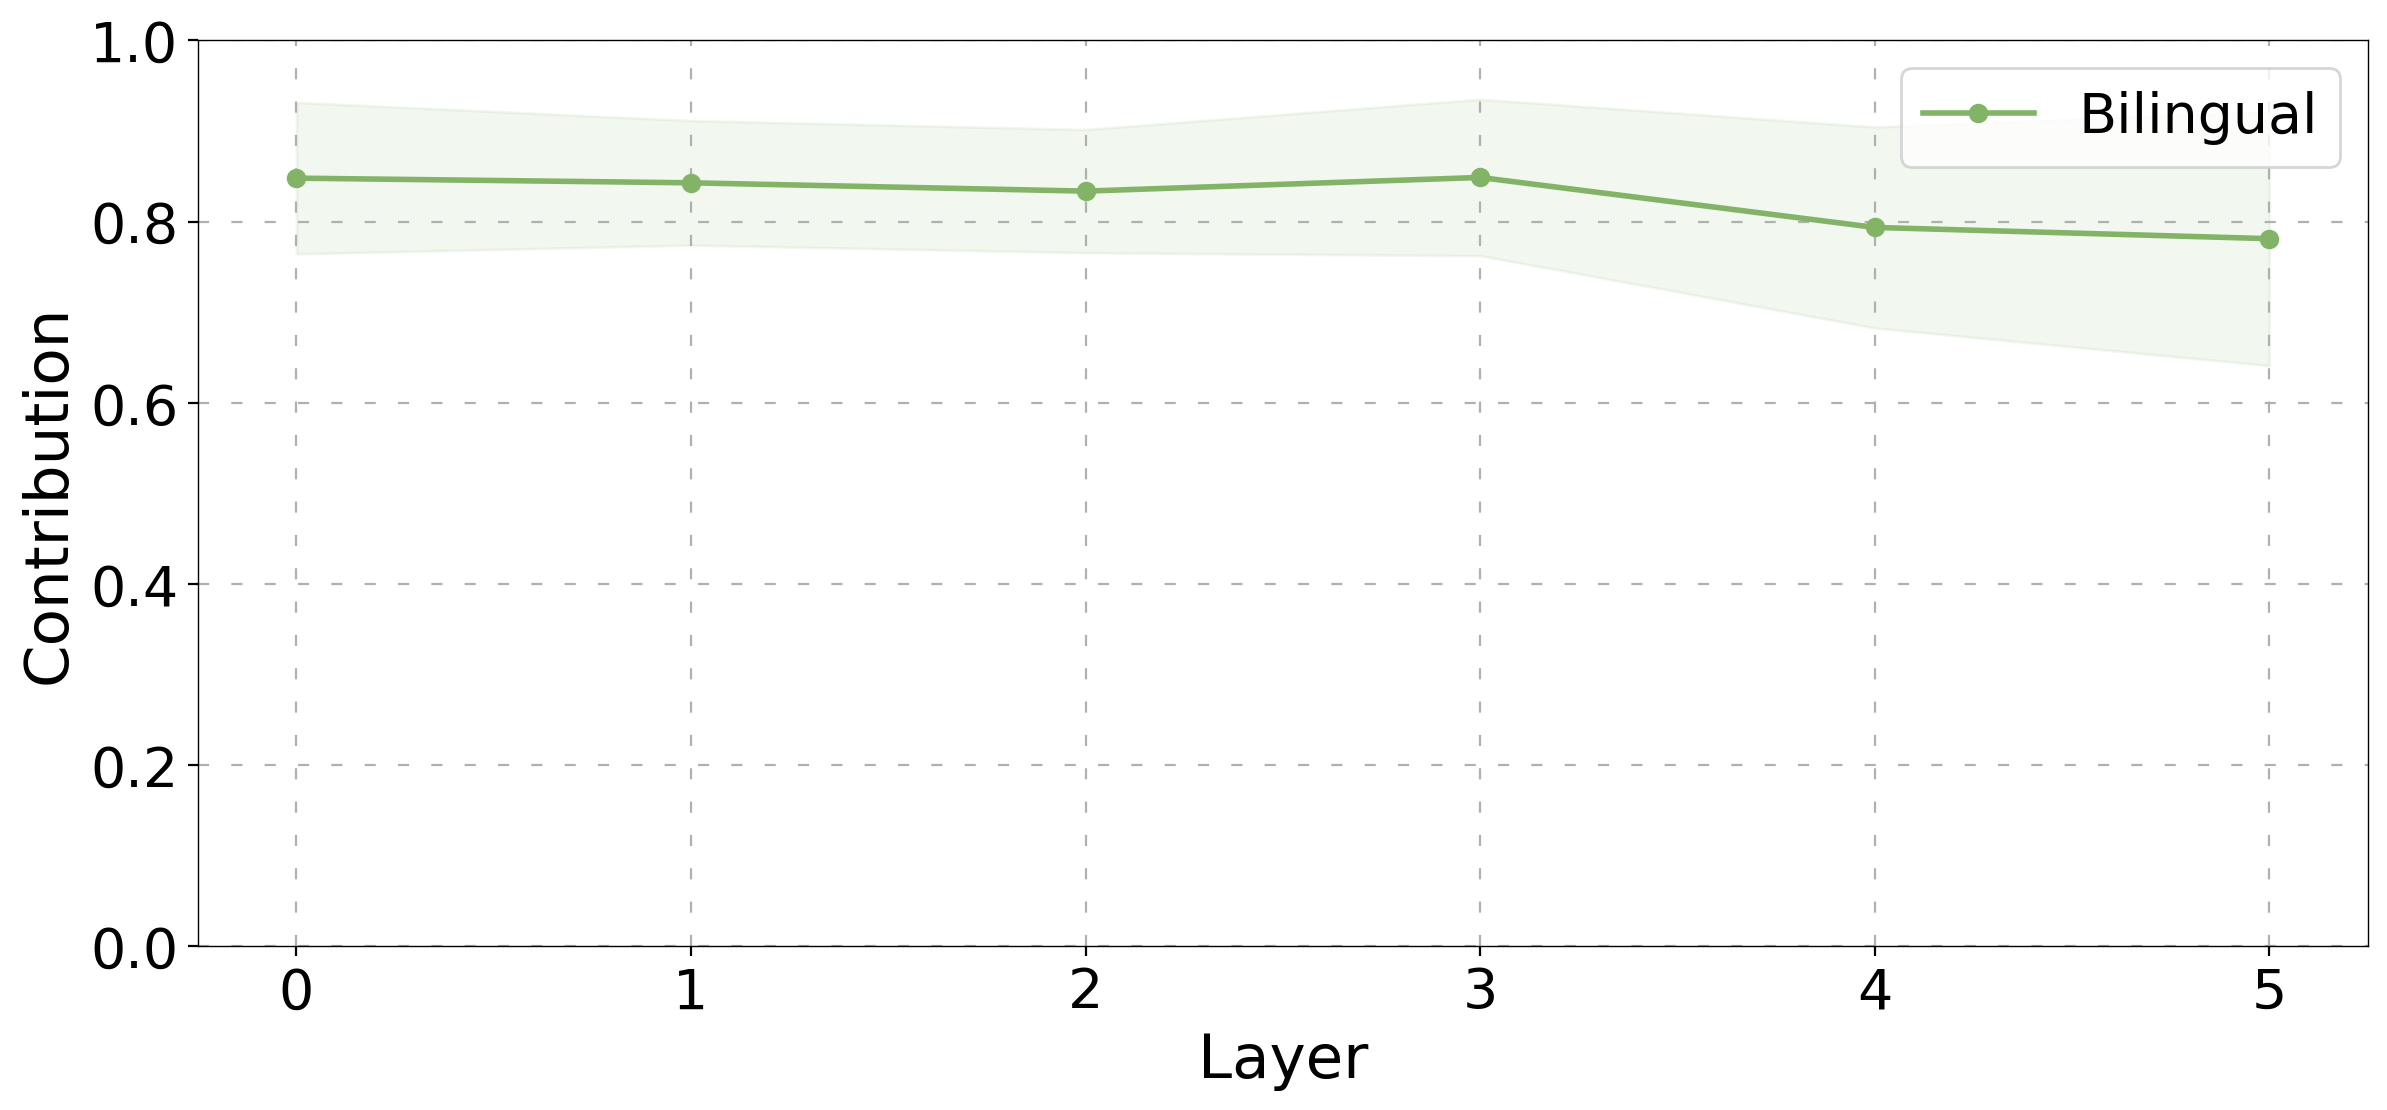

In [33]:
data = [0]*2
x_ticks = [0]*2
x_ticks[0], data[0] = [*zip(*res_dict_list.items())]  # 'transpose' items to parallel key, value lists
#x_ticks[1], data[1] = [*zip(*mix_dict_multilingual.items())]  # 'transpose' items to parallel key, value lists

#x_ticks = [1,2,3,4,5,6]
color = ['#82B366','#6C8EBF','#D79B00']
labels = ['Bilingual', 'Multilingual']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(14, 6),dpi=200)

for i in range(1):
    mean_data = [statistics.mean(j) for j in data[i]] # mean per head
    std_data = [statistics.stdev(j) for j in data[i]] # std per head
    ax.plot(x_ticks[i], mean_data, color[i], markersize=6, linewidth=2, linestyle='-',alpha = 1, marker='o',label=labels[i])
    ax.fill_between(x_ticks[i], (np.array(mean_data)-np.array(std_data)), (np.array(mean_data)+np.array(std_data)), color=color[i], alpha=.1)


ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel('Contribution')
ax.legend(prop={'size': 20})
ax.grid(True, linestyle=(0, (5, 10)));

In [7]:
outfile = f'./results/bilingual_iwslt_eos_res_corr.json'
f = open(outfile)
corr_dict_bilingual = json.load(f)
outfile = f'./results/multilingual_iwslt_eos_res_corr.json'
f = open(outfile)
corr_dict_multilingual = json.load(f)

<class 'tuple'>
[1 2 3 4 5 6]


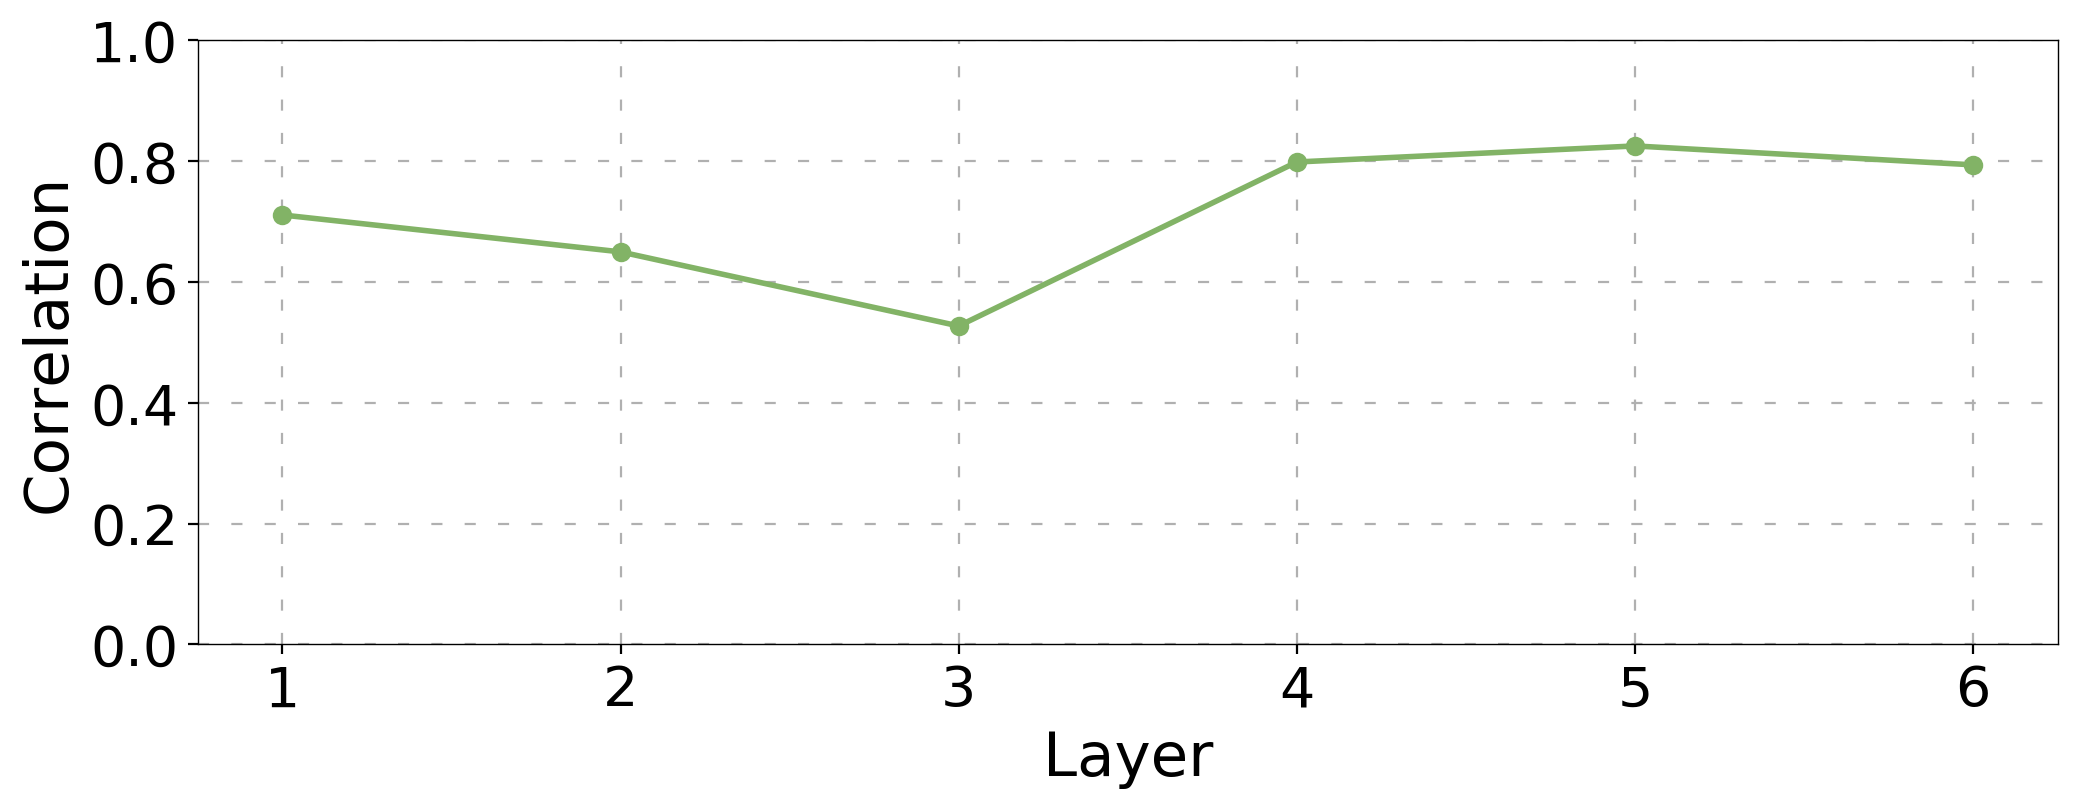

In [25]:

data = [0]*2
x_ticks_list = [0]*2
x_ticks_list[0], data[0] = [*zip(*corr_dict_bilingual.items())]  # 'transpose' items to parallel key, value lists
x_ticks_list[1], data[1] = [*zip(*corr_dict_multilingual.items())]  # 'transpose' items to parallel key, value lists

x_ticks = np.arange(1,7)
color = ['#82B366','#6C8EBF']#,'#D79B00']
labels = ['Bilingual', 'Multilingual']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(12, 4),dpi=200)

for i in range(1):
    print(type(data[i]))
    print(x_ticks)
    ax.plot(x_ticks, data[i], 'b', markersize=6, linewidth=2,
            linestyle='-',alpha = 1, marker='o',color=color[i],
            label = labels[i])


ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel(r'Correlation')
ax.grid(True, linestyle=(0, (5, 10)))
#plt.grid(False, linewidth=0.25);
#plt.legend(prop={'size': 16})
#ax.legend(loc=(0.05,0.12),prop={'size': 20})
# ax.set_xticks([1,2,3,4]);
# ax.set_yticks([1,2,3,4]);
#ax.set_xticklabels(x_ticks);

## Encoder mixing Analysis

In [9]:
# dataset = 'iwslt'
# if dataset == 'iwslt':
#     test_set_dir = iwslt14_dir / "tokenized/"
# elif dataset == 'gold':
#     test_set_dir = europarl_dir / "processed_data/"

args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir
    )
contributions = True
results_dict = defaultdict(list)
length_sentences = []

i = 0
counter = 0

while counter < 1000:
    if counter%100==0:
        print(counter)
    sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
    src_tensor = sample['src_tensor']
    src_tok = sample['src_tok']
    if len(src_tok)>50:
        i += 1
        continue
    #     relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
    length_sentences.append(len(src_tok))
    tgt_tensor, _ = get_greedy_decoding(hub, src_tensor)

    relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                            norm_mode='min_sum',
                                                            pre_layer_norm=pre_layer_norm)['encoder.self_attn']
    relevances_enc_self_attn = relevances_enc_self_attn.detach().cpu()
    
    for layer in range(NUM_LAYERS):
        total_contrib = relevances_enc_self_attn[layer].sum()
        diag_sum = torch.diagonal(relevances_enc_self_attn[layer]).sum()
        #key = f'{layer}'
        results_dict[layer].append((diag_sum/total_contrib).numpy().item())
    #results_dict['stds'].append(torch.diagonal(relevances_enc_self_attn[-1]).std().item())
    

    counter += 1
    i += 1

    #total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()


0
0
0
100
100
200
300
400
500
600
700
700
800
900


In [37]:
# results_dict_lists = defaultdict(list)
# for key in results_dict.keys():
#     results_dict_lists[key] = [float(v) for v in results_dict[key]]


In [10]:
outfile = f'./results/{model}_{dataset}_encoder_mixing.json'
with open(outfile, 'w') as f:
    json.dump(results_dict, f)

In [26]:
outfile = f'./results/bilingual_iwslt_encoder_mixing.json'
f = open(outfile)
mix_dict_bilingual = json.load(f)
outfile = f'./results/multilingual_iwslt_encoder_mixing.json'
f = open(outfile)
mix_dict_multilingual = json.load(f)

In [81]:
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'xtick.labelsize' : 20})
plt.rcParams.update({'ytick.labelsize' : 20})
plt.rcParams.update({'axes.titlesize' : 24})
plt.rcParams.update({'axes.labelsize' : 22})

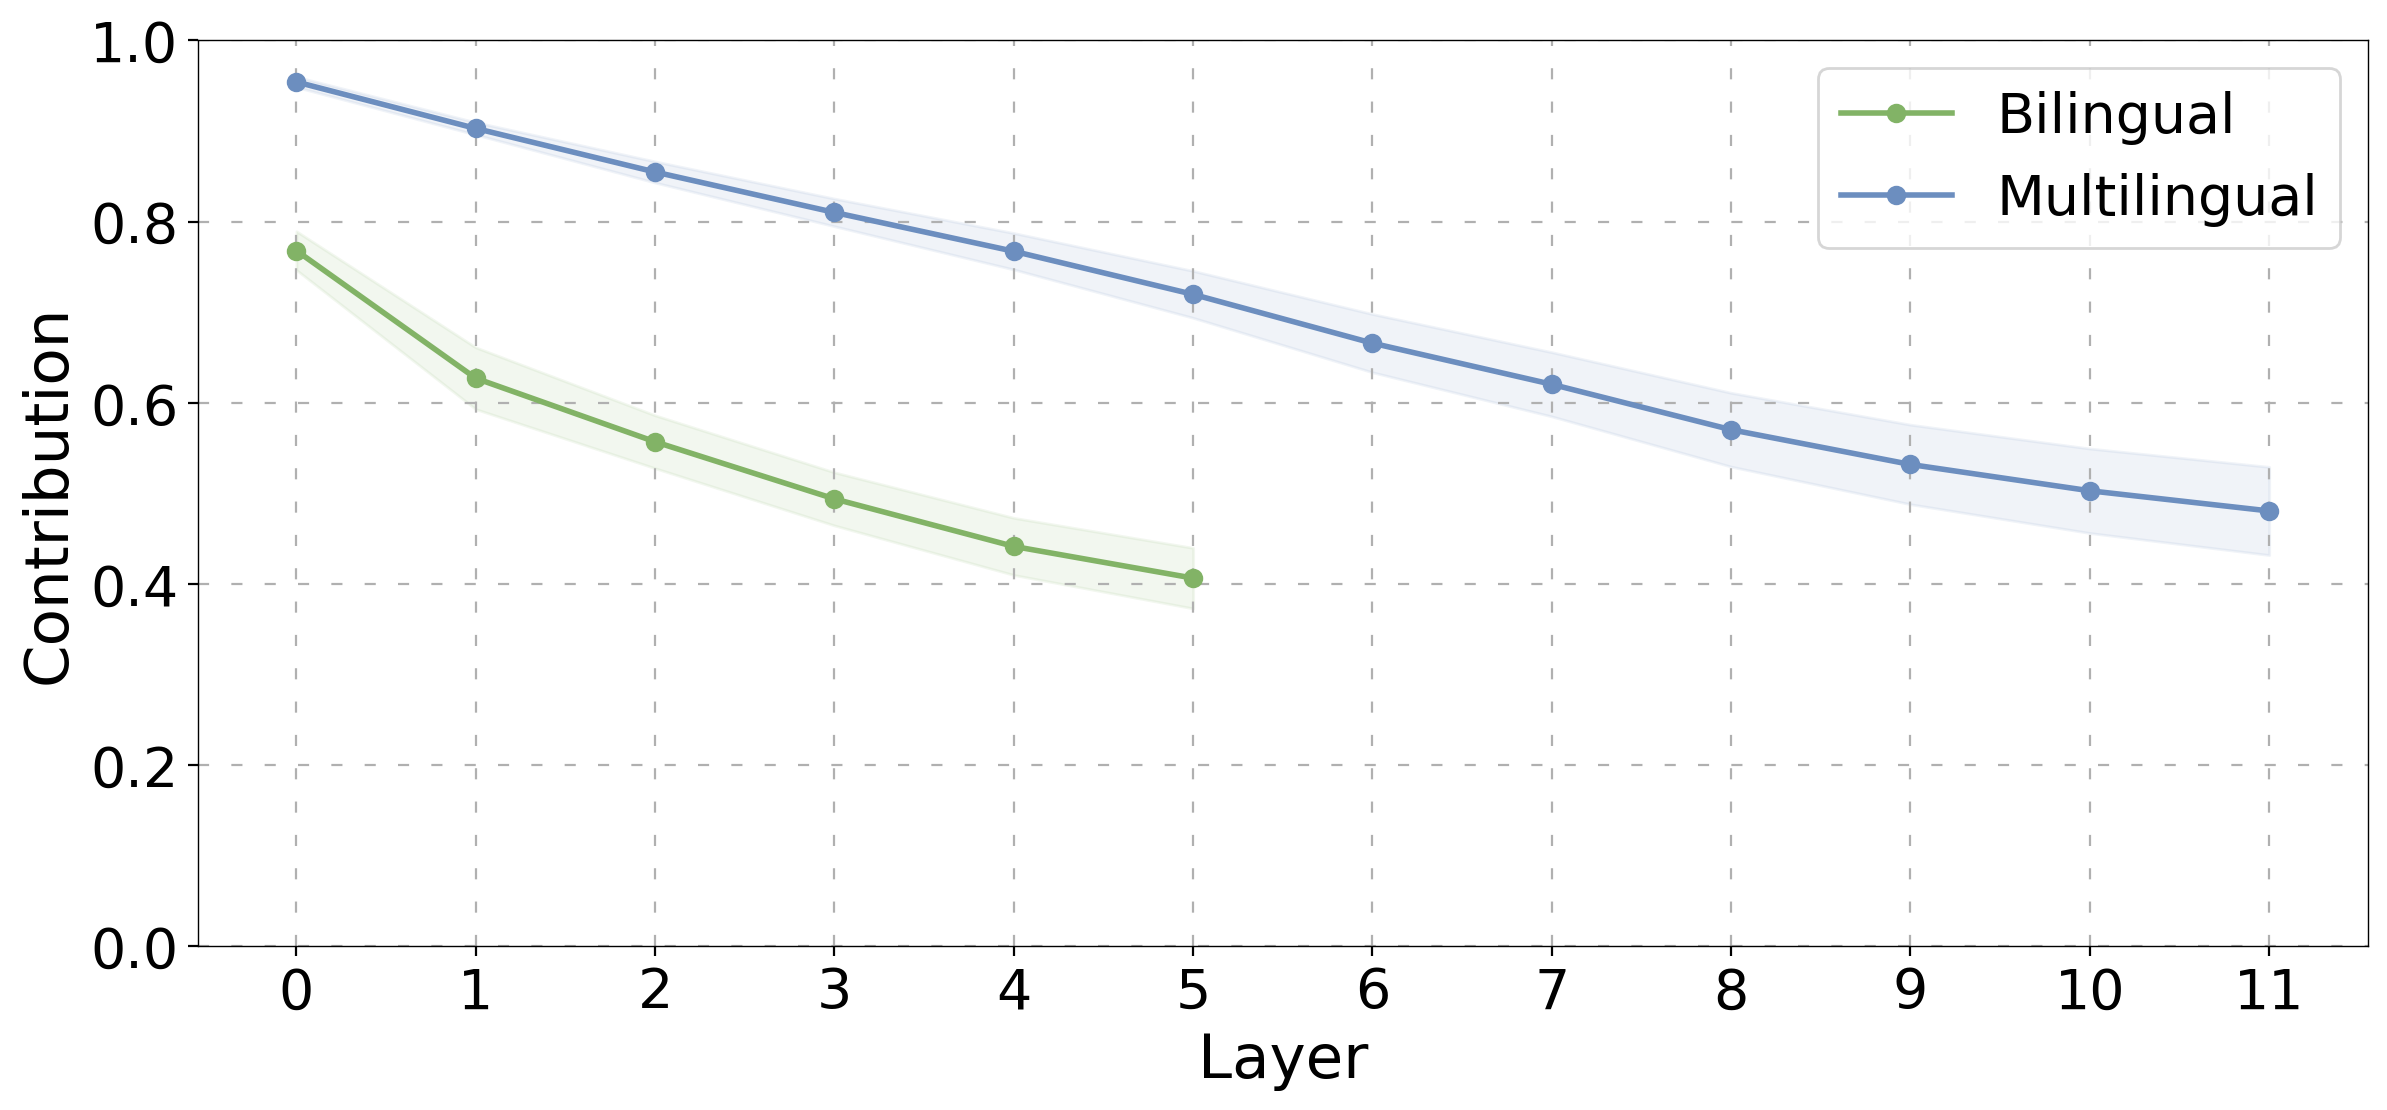

In [27]:
data = [0]*2
x_ticks = [0]*2
x_ticks[0], data[0] = [*zip(*mix_dict_bilingual.items())]  # 'transpose' items to parallel key, value lists
x_ticks[1], data[1] = [*zip(*mix_dict_multilingual.items())]  # 'transpose' items to parallel key, value lists

#x_ticks = [1,2,3,4,5,6]
color = ['#82B366','#6C8EBF','#D79B00']
labels = ['Bilingual', 'Multilingual']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(14, 6),dpi=200)

for i in range(2):
    mean_data = [statistics.mean(j) for j in data[i]] # mean per head
    std_data = [statistics.stdev(j) for j in data[i]] # std per head
    ax.plot(x_ticks[i], mean_data, color[i], markersize=6, linewidth=2, linestyle='-',alpha = 1, marker='o',label=labels[i])
    ax.fill_between(x_ticks[i], (np.array(mean_data)-np.array(std_data)), (np.array(mean_data)+np.array(std_data)), color=color[i], alpha=.1)


ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel('Contribution')
#plt.legend(prop={'size': 16})
#ax.legend(loc=(0.05,0.12),prop={'size': 20})
ax.legend(prop={'size': 20})
ax.grid(True, linestyle=(0, (5, 10)));
#plt.grid(False, linewidth=0.25)

#ax.grid(True)
#ax.set_xticks([1,2,3,4,5,6]);
#ax.set_yticks([1,2,3,4,5,6]);
#ax.set_xticklabels(x_ticks);

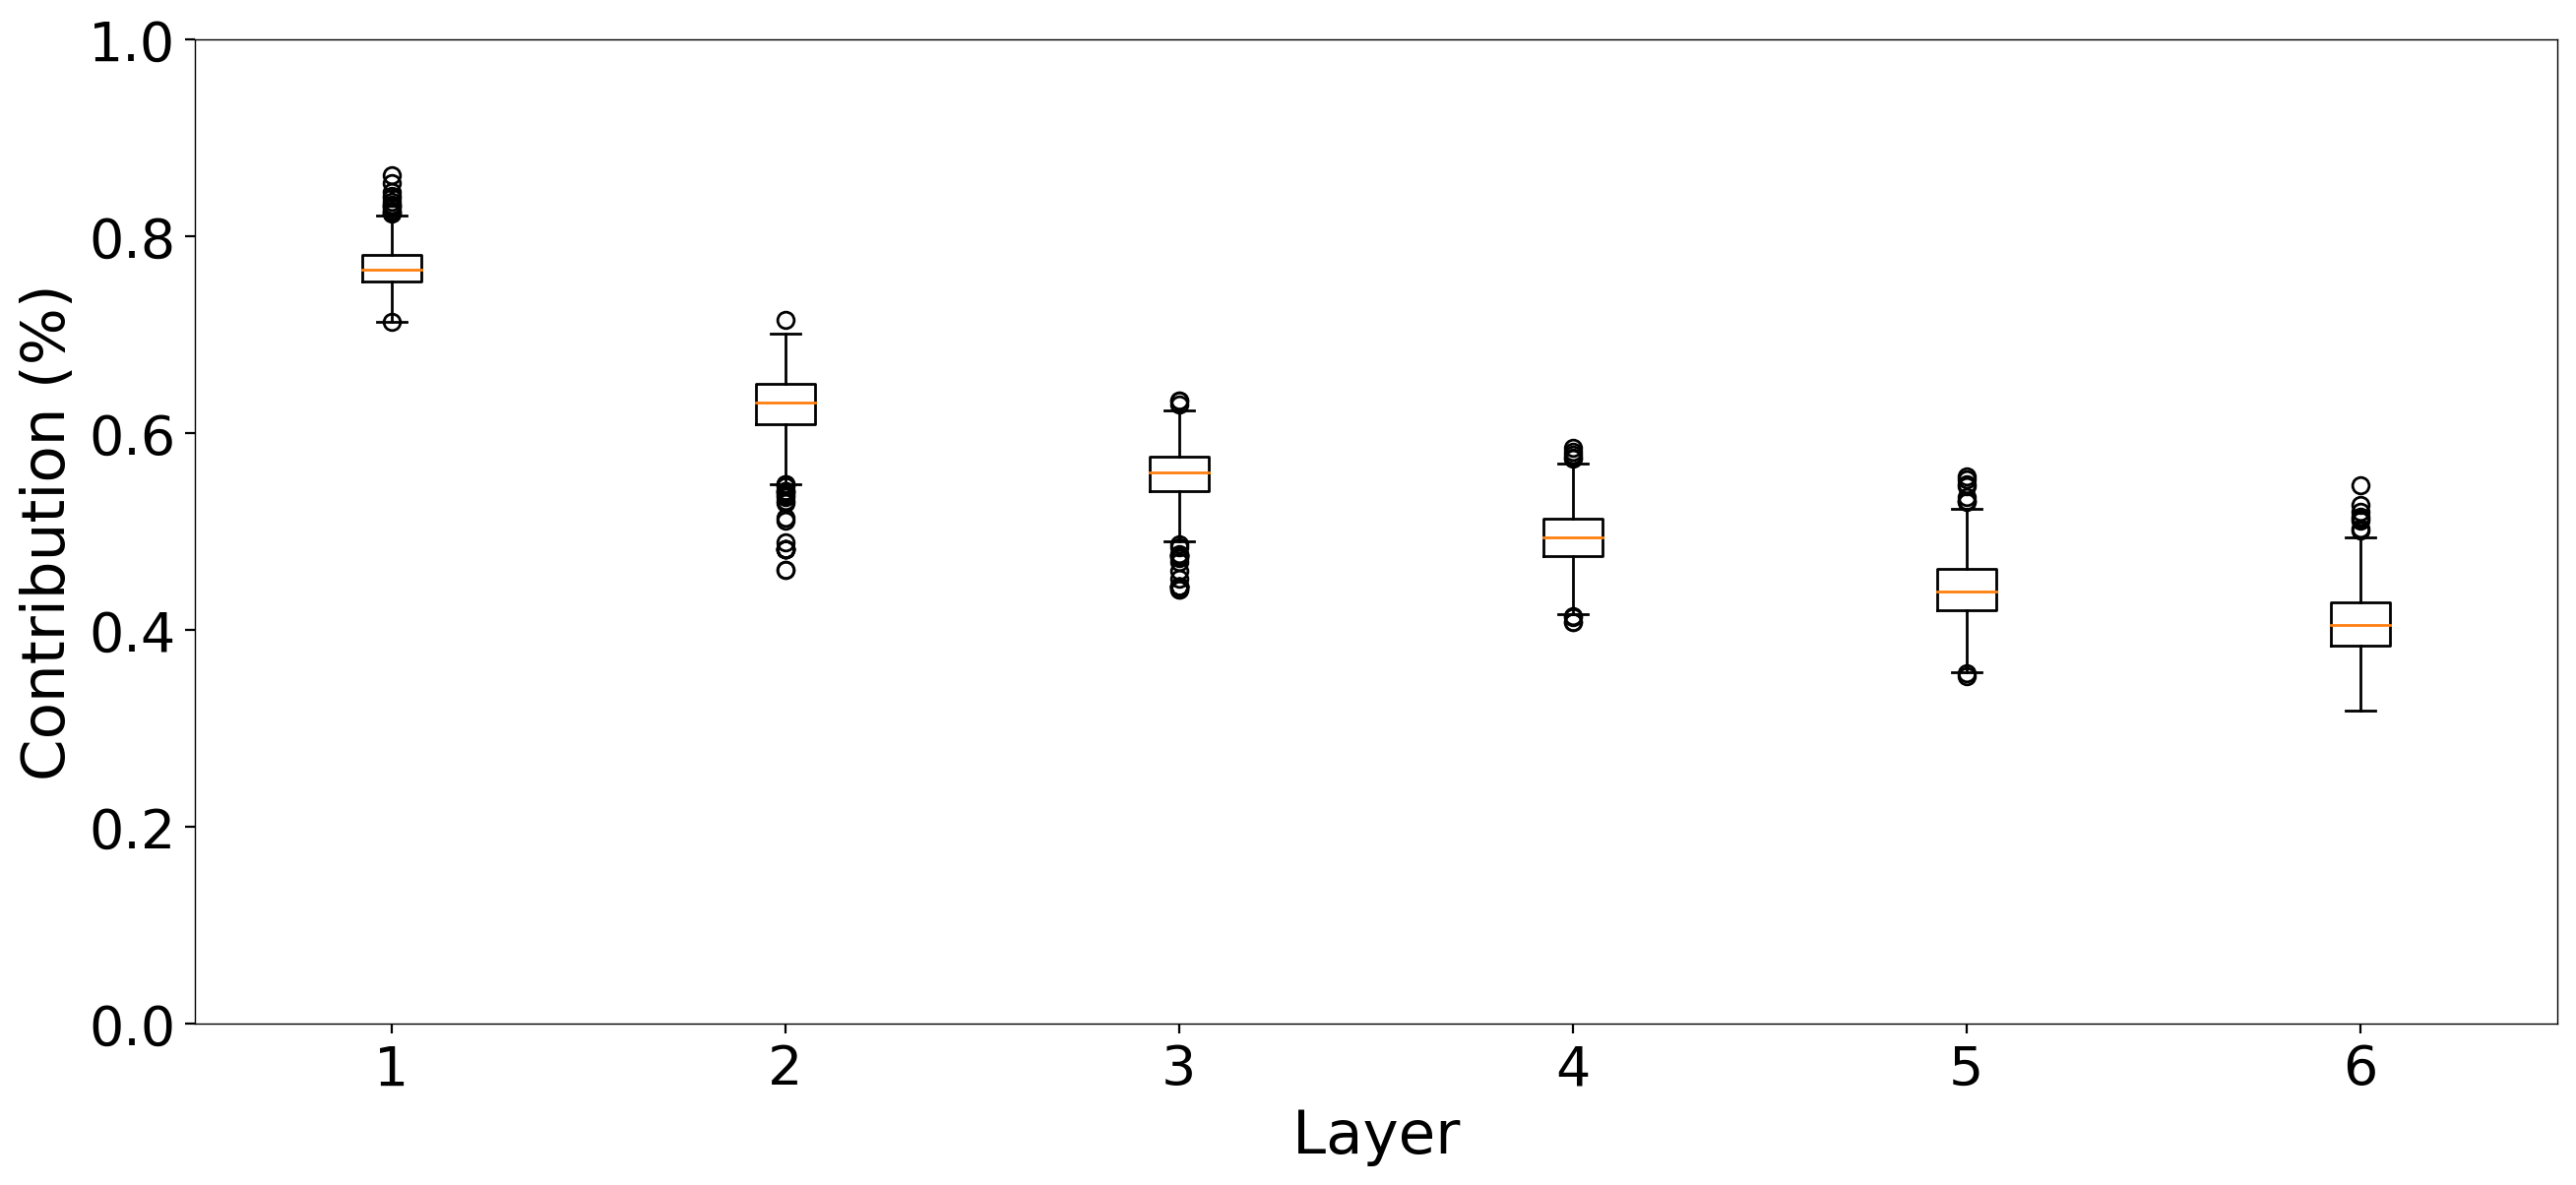

In [12]:
fig = plt.figure(figsize =(12, 5),dpi=200)
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
for i in range(1,7):
    ax.boxplot(results_dict[i], positions = [i])
# Creating plot
#bp = ax.boxplot(data_4)
ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel('Contribution (%)')
#plt.grid(True)
# show plot
plt.show()

<Figure size 2000x2000 with 0 Axes>

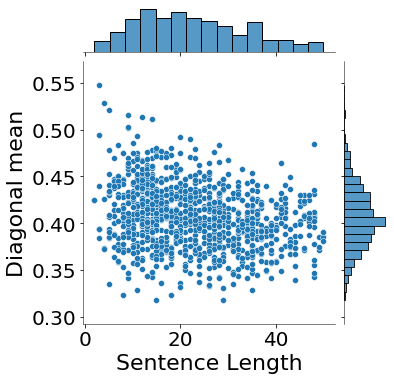

In [ ]:
dict_data = {'Diagonal mean':results_dict['means'], 'Sentence Length':length_sentences}
df = pd.DataFrame(dict_data)
plt.figure(figsize=(10,10),dpi=200)
#df.plot.scatter(x = 'length', y = 'means');
sns.jointplot(x=df["Sentence Length"], y=df["Diagonal mean"], kind='scatter')


In [13]:
total_sentences = len(results_dict['means'])
print(f'Total of {total_sentences} sentences')
print('Mean: ', statistics.mean(results_dict['means']))
print('Std: ', statistics.mean(results_dict['stds']))

Total of 1000 sentences
Mean:  0.40651998993754385
Std:  0.19392589148879052


## Values vectors analysis

In [10]:
args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir
    )
contributions = True
alignment_layer = 4
head_dim = 128
num_heads = 4
eos_dict = defaultdict(list)
final_punct_dict = defaultdict(list)
rest_tokens_dict = defaultdict(list)

i = 0
counter = 0

while counter < 1000:
    if counter%100==0:
        print(counter)
    sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
    src_tensor = sample['src_tensor']
    src_tok = sample['src_tok']
    if len(src_tok)>50:
        i += 1
        continue
    # if len(src_tok)>20 and len(src_tok)<23:
    #     relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
        
    tgt_tensor, _ = get_greedy_decoding(hub, src_tensor)

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)
    values = torch.squeeze(layer_outputs[f'models.0.decoder.layers.{alignment_layer}.encoder_attn.v_proj'][0]).detach().cpu()
    v = torch.squeeze(values.contiguous().view(-1, num_heads, head_dim).transpose(0, 1)) # heads,src_len,128
    eos_value = v[:,-1,:]
    final_punct_value = v[:,-2,:]
    rest_tokens_value = v[:,:-2,:]
    
    #random_value = values[-3]
    
    for head in range(num_heads):
        eos_dict[head].append(eos_value[head].norm(dim=-1).tolist())
        final_punct_dict[head].append(final_punct_value[head].norm(dim=-1).tolist())
        rest_tokens_dict[head].append(rest_tokens_value[head].norm(dim=-1).mean().tolist())
    
    counter += 1
    i += 1

    #total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()


0
0
0
100
200
300
400
500
600
600
600
700
800
800
900


In [13]:
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'xtick.labelsize' : 20})
plt.rcParams.update({'ytick.labelsize' : 20})
plt.rcParams.update({'axes.titlesize' : 24})
plt.rcParams.update({'axes.labelsize' : 22})

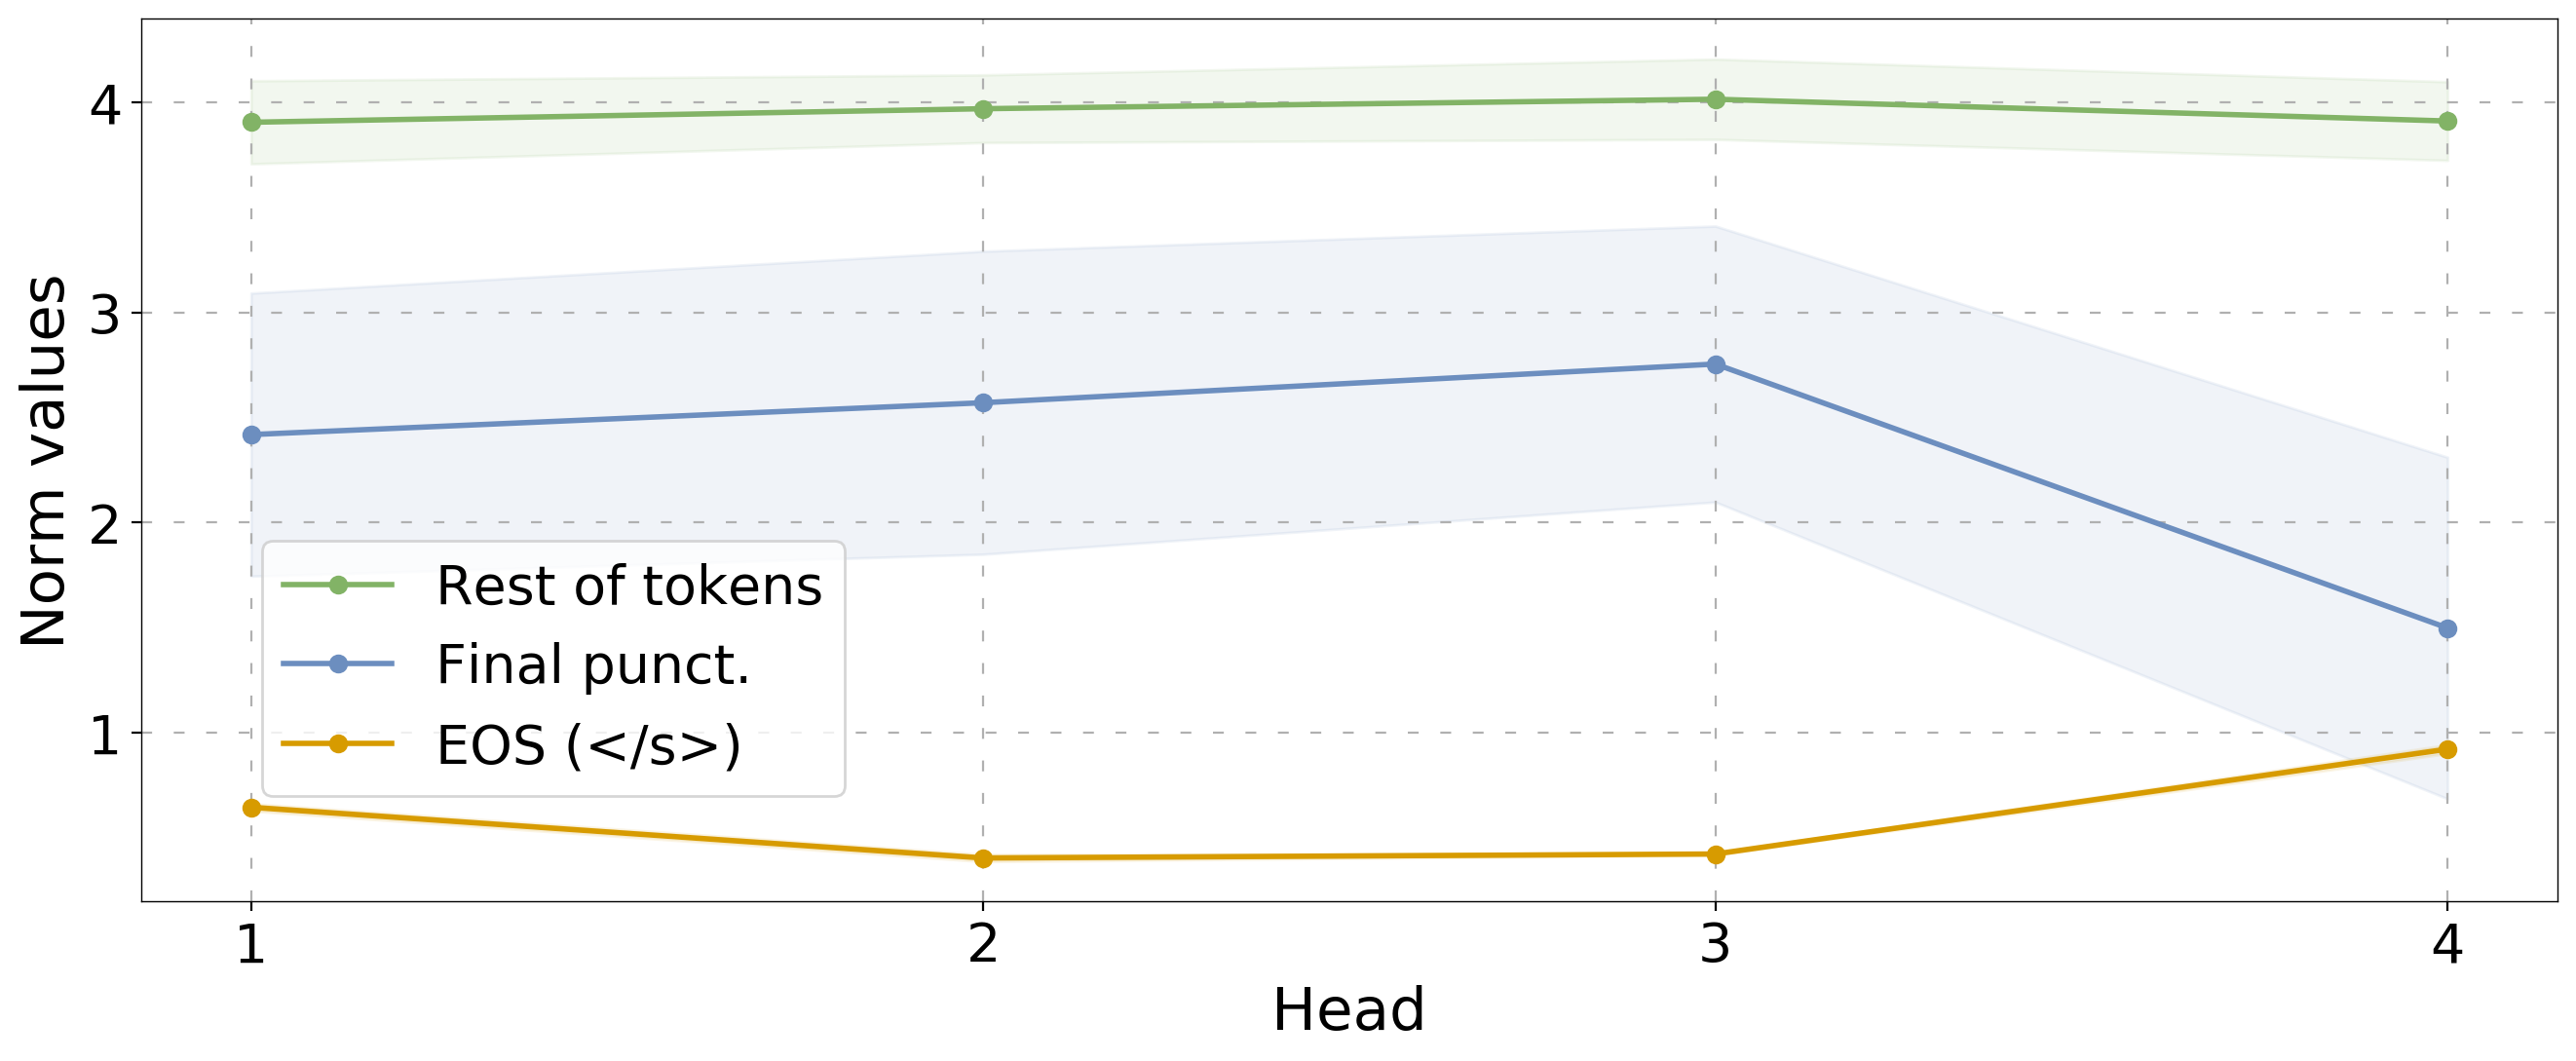

In [24]:

data = [0]*3

labels, data[2] = [*zip(*eos_dict.items())]  # 'transpose' items to parallel key, value lists
labels, data[1] = [*zip(*final_punct_dict.items())]  # 'transpose' items to parallel key, value lists
labels, data[0] = [*zip(*rest_tokens_dict.items())]  # 'transpose' items to parallel key, value lists
x_ticks = [1,2,3,4]
color = ['#82B366','#6C8EBF','#D79B00']
labels = ['Rest of tokens', 'Final punct.', 'EOS (</s>)']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(16, 6),dpi=200)
for i in range(3):
    mean_data = [statistics.mean(j) for j in data[i]] # mean per head
    std_data = [statistics.stdev(j) for j in data[i]] # std per head
    ax.plot(x_ticks, mean_data, color[i], markersize=6, linewidth=2, linestyle='-',alpha = 1, marker='o',label=labels[i])
    ax.fill_between(x_ticks, (np.array(mean_data)-np.array(std_data)), (np.array(mean_data)+np.array(std_data)), color=color[i], alpha=.1)


#ax.set_ylim(0,4)
plt.xlabel('Head')
plt.ylabel('Norm values')
#plt.legend(prop={'size': 16})
ax.legend(loc=(0.05,0.12),prop={'size': 20})
ax.grid(True, linestyle=(0, (5, 10)))
ax.set_xticks([1,2,3,4]);
#ax.set_yticks([1,2,3,4]);
#plt.grid(False, linewidth=0.25, linestyle='--');
#ax.set_xticklabels(x_ticks);

torch.Size([18, 4])


Text(0.5, 1.0, 'Norm K vectors')

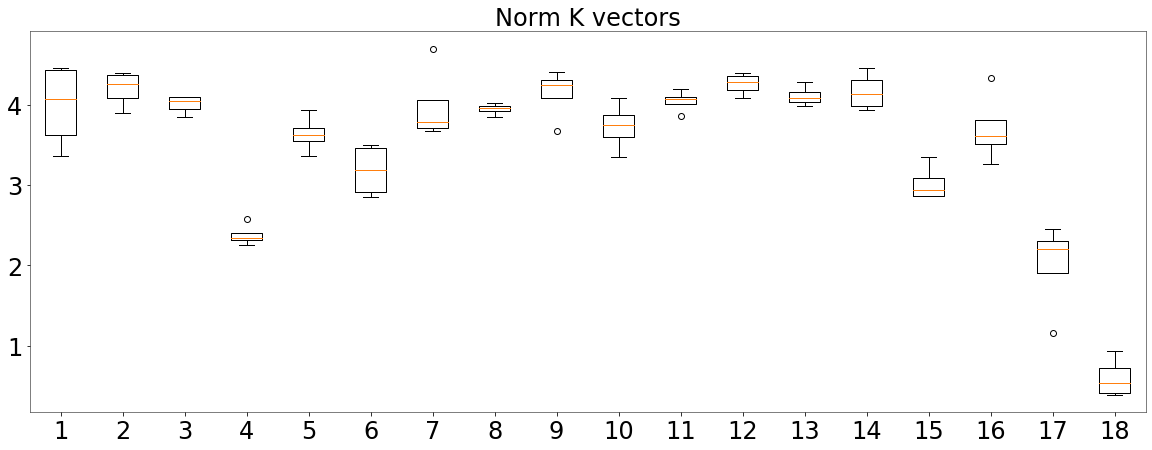

In [19]:
transformed_vectors_box = v.norm(dim=2).data
transformed_vectors_box = transformed_vectors_box.permute(1,0)
print(transformed_vectors_box.size())
  
# Creating plot 
fig = plt.figure(figsize =(20, 7)) 
ax = fig.add_subplot(111) 

ax.boxplot(transformed_vectors_box);
ax.set_title('Norm K vectors')
#ax.set_xticklabels(en_list, rotation=45, fontsize=20);